# Solving optimal control problems with policy gradient method 

In [122]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float32) # improved the speed when the parameters are float32
import random

import json

from IPython.display import display, Math, Markdown

import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_0.1.0'
import math
PI = math.pi

## Defining control by a neural network

$$\phi(t,x;\theta)$$



In [123]:
num_neurons = 20 # Modify the number of neurons

model = torch.nn.Sequential(
            torch.nn.Linear(2, num_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(num_neurons,1),
        )

## Predefine global variables

In [124]:
N = 10 # number of time steps
T = 1.0 # terminal time
dt = T/N # time step
num_samples = 1_000 # Modify the number of samples
x0 = 2*torch.rand([num_samples,1]) -1 # initial condition uniformly random in [-1,1]
dW = torch.sqrt(torch.tensor(dt))*torch.randn([num_samples,N,1]) # Brownian increments

## State variable

$$dX_t = (x_t-u_t)dt + dW_t$$

$$u_t=\phi(t,x_t,\theta)$$

In [125]:
# update function evolution of the state over time
def update(t,x,u):
    return x + (x -  u)*dt + dW[:,t,:]

## Loss function 

$$C(x,u)=x^2+x+u^2$$

$$g(x)=x^2-x$$

In [126]:
def step_loss(t,x,model):
    # fix concatinate t and x before plugging it into the model
    T = torch.ones_like(x)*t*dt
    tx = torch.concat((T,x),dim=1)
    u = model(tx)
    return torch.mean(x**2+x+u**2)*dt

def total_loss(model):
    x = x0
    running_cost = 0.0
    for t in range(N):
        # fix concatinate t and x before plugging it into the model
        T = torch.ones_like(x)*t*dt
        tx = torch.concat((T,x),dim=1)
        u = model(tx)
        running_cost = running_cost + step_loss(t,x,model)
        x = update(t,x,u)
    terminal_cost = torch.mean(x**2 - x)
    total_loss = running_cost + terminal_cost
    return total_loss

## Generate the number of samples

In [127]:
num_epochs = 100
learning_rate = 1e-2
# optimizer = optim.Adam(model.parameters(), learning_rate)
optimizer = optim.SGD(model.parameters(), learning_rate,momentum=0.9)
loss_history = []
for e in range(num_epochs):
    loss = total_loss(model)#.clone().detach().requires_grad_(True)
    optimizer.zero_grad() # Zero the gradients before running the backward pass.
    loss.backward() # Backward pass: compute gradient of the loss with respect to all the learnable parameters
    loss_history.append(loss.item())
    if e % (num_epochs//10) == 0:
        print(e+1, loss)
    optimizer.step() # Update the weights and biases using gradient descent. Each parameter is a Tensor. Equivalent to the above three lines, but more efficient.

1 tensor(7.3468, grad_fn=<AddBackward0>)
11 tensor(2.4745, grad_fn=<AddBackward0>)
21 tensor(2.8196, grad_fn=<AddBackward0>)
31 tensor(2.4752, grad_fn=<AddBackward0>)
41 tensor(2.4744, grad_fn=<AddBackward0>)
51 tensor(2.4237, grad_fn=<AddBackward0>)
61 tensor(2.4159, grad_fn=<AddBackward0>)
71 tensor(2.4040, grad_fn=<AddBackward0>)
81 tensor(2.3989, grad_fn=<AddBackward0>)
91 tensor(2.3946, grad_fn=<AddBackward0>)


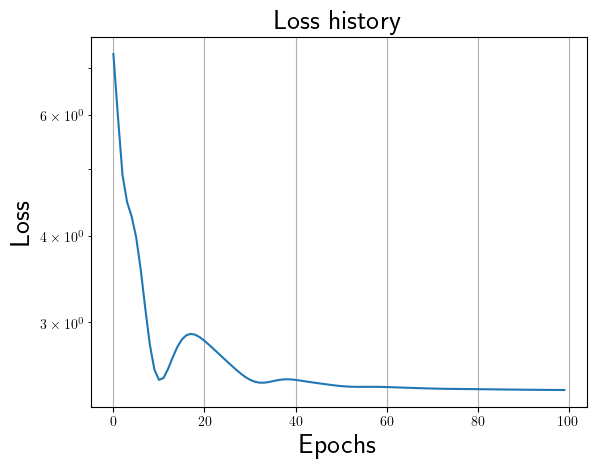

In [128]:
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epochs',fontproperties=font)
plt.ylabel('Loss',fontproperties=font)
plt.title('Loss history',fontproperties=font)
plt.grid()
plt.show()